In [1]:
import os

BASE_DIR      = r"C:\Users\User\KS"      
PROCESSED_OUT = os.path.join(BASE_DIR, "Processed")
RESULTS_OUT   = os.path.join(BASE_DIR, "Results")

TARGET_DATASET = "ALL_combined"             

print("BASE_DIR      :", BASE_DIR)
print("PROCESSED_OUT :", PROCESSED_OUT)
print("RESULTS_OUT   :", RESULTS_OUT)
print("TARGET_DATASET:", TARGET_DATASET)

BASE_DIR      : C:\Users\User\KS
PROCESSED_OUT : C:\Users\User\KS\Processed
RESULTS_OUT   : C:\Users\User\KS\Results
TARGET_DATASET: ALL_combined


In [2]:
import json
import pandas as pd

baseline_csv = os.path.join(PROCESSED_OUT, f"{TARGET_DATASET}.csv")
final_csv    = os.path.join(RESULTS_OUT,   f"{TARGET_DATASET}_parsed_final.csv")
state_path   = os.path.join(RESULTS_OUT,   f"{TARGET_DATASET}_drain3_state.json")

print("Baseline CSV :", baseline_csv, "| exists:", os.path.exists(baseline_csv))
print("Final CSV    :", final_csv,    "| exists:", os.path.exists(final_csv))
print("Drain3 state :", state_path,   "| exists:", os.path.exists(state_path))

base_df  = pd.read_csv(baseline_csv, dtype=str).fillna("")
final_df = pd.read_csv(final_csv,    dtype=str).fillna("")

print("\nBaseline columns:", base_df.columns.tolist())
print("Final columns   :", final_df.columns.tolist())


with open(state_path, "r", encoding="utf-8", errors="ignore") as f:
    state = json.load(f)

cluster_template = {
    str(c["cluster_id"]): c.get("template", "")
    for c in state.get("clusters", [])
}

print("\nDrain3 clusters loaded:", len(cluster_template))


Baseline CSV : C:\Users\User\KS\Processed\ALL_combined.csv | exists: True
Final CSV    : C:\Users\User\KS\Results\ALL_combined_parsed_final.csv | exists: True
Drain3 state : C:\Users\User\KS\Results\ALL_combined_drain3_state.json | exists: True

Baseline columns: ['dataset', 'line_no', 'timestamp', 'level', 'component', 'message', 'template']
Final columns   : ['timestamp', 'level', 'source', 'template', 'raw', 'template_id', 'fuzzy_score']

Drain3 clusters loaded: 15276


In [3]:
from rapidfuzz import fuzz

final_df["cluster_template"] = (
    final_df["template_id"]
        .fillna("T-1")
        .str.replace("T", "", regex=False)
        .astype(int, errors="ignore")
        .astype(str)
        .map(cluster_template)
        .fillna("")
)


base_df_renamed = base_df.rename(columns={
    "message": "raw",
    "template": "baseline_template"
})

merged = pd.merge(
    final_df,
    base_df_renamed[["raw", "baseline_template"]],
    on="raw",
    how="inner"
)

print("Merged rows   :", len(merged))
print("Merged columns:", merged.columns.tolist())

Merged rows   : 724544
Merged columns: ['timestamp', 'level', 'source', 'template', 'raw', 'template_id', 'fuzzy_score', 'cluster_template', 'baseline_template']


In [4]:
baseline_unique = merged["baseline_template"].nunique()
t5_unique       = merged["template"].nunique()
drain_unique    = merged["template_id"].nunique()

summary = pd.DataFrame({
    "Stage": ["Baseline regex/mask", "T5 Templates", "T5 + Drain3 Clusters"],
    "Unique Templates": [baseline_unique, t5_unique, drain_unique]
})

summary["Compression vs Baseline (%)"] = (
    100 * (1 - summary["Unique Templates"] / baseline_unique)
).round(4)

print("Template count & compression:")
summary


Template count & compression:


,Stage,Unique Templates,Compression vs Baseline (%)
0,Baseline regex/mask,101804,0.0000
1,T5 Templates,52742,48.1926
2,T5 + Drain3 Clusters,15276,84.9947


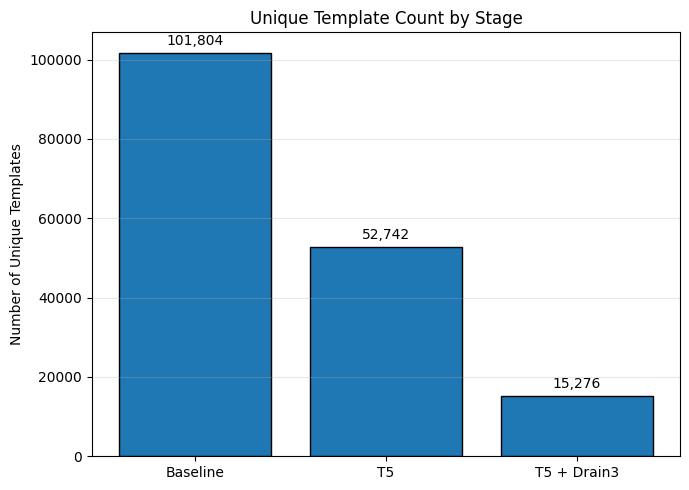

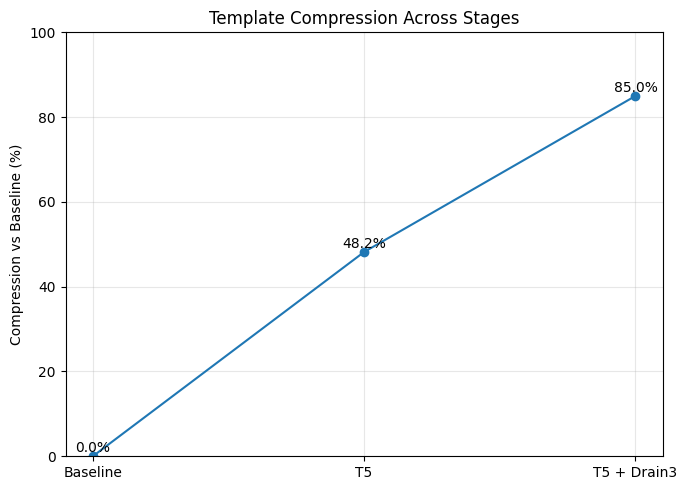

In [6]:
import matplotlib.pyplot as plt

stages = ["Baseline", "T5", "T5 + Drain3"]
uniq_values = [baseline_unique, t5_unique, drain_unique]


plt.figure(figsize=(7,5))
bars = plt.bar(stages, uniq_values, edgecolor="black")
for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h + 2000, f"{int(h):,}", ha="center")
plt.ylabel("Number of Unique Templates")
plt.title("Unique Template Count by Stage")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


compression_values = [
    0.0,
    100 * (1 - t5_unique / baseline_unique),
    100 * (1 - drain_unique / baseline_unique)
]

plt.figure(figsize=(7,5))
plt.plot(stages, compression_values, marker="o")
for x, y in zip(stages, compression_values):
    plt.text(x, y + 1, f"{y:.1f}%", ha="center")
plt.ylabel("Compression vs Baseline (%)")
plt.ylim(0, 100)
plt.title("Template Compression Across Stages")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
